# Using OpenSTL in your own project

In this notebook, we will provide a comprehensive guide on how to use OpenSTL for your own project. 

Firstly, we will process video data into `.npy` format for easier storage and access. Next, we will demonstrate how to utilize custom data within OpenSTL. Subsequently, we will use OpenSTL to train and evaluate models. Finally, we will visualize predicted frames and generate `.gif` images or videos. 

- [1. Preprocess your data](#1-process-your-data)
    - [1.1 Save the dataset](#11-save-the-dataset)
    - [1.2 Load the dataset and visualize an example](#12-load-the-dataset-and-visualize-an-example)

- [2. Utilize cumtom data](#2-utilize-cumtom-data)
    - [2.1 Define the dataset](#21-define-the-dataset)
    - [2.2 Get the dataloaders](#22-get-the-dataloaders)

- [3. Train and evaluate](#3-train-and-evaluate)
    - [3.1 Define the custom configs](#31-define-the-custom-configs)
    - [3.2 Setup the experiment](#32-setup-the-experiment)
    - [3.3 Start training and evaluation](#33)

- [4. Visualization](#4-visualization)
    - [4.1 Visualize in a line](#41-visualize-in-a-line)
    - [4.2 Generate a GIF](#42-generate-a-gif)

Here we go!

## 1. Process your data

Assume you possess a collection of videos and have already sorted them into the `train/`, `val/`, and `test/` directories. The subsequent step involves transforming these videos into a `.pkl` file for further manipulations.

The existing file hierarchy is as follows:

- custom_usage.ipynb
- train
  - train_example1.avi
  - train_example2.avi
- val
  - val_example1.avi
  - val_example2.avi
- test
  - test_example.avi

It's crucial to note that the above example represents a simplified scenario where we've used `.avi` videos for illustrative purposes. However, in a real-world application, you are free to employ videos in various other formats.

We utilize several videos from the KTH dataset as examples. Although the original KTH dataset consists of single-channel grayscale videos, we save them as three-channel RGB videos to accommodate a broader range of use cases.

### 1.1 Save the dataset

Here, we default to uniformly sampling several frames from the given video data. The number of observed frames and future frames are two hyperparameters (`pre_seq_length`, `aft_seq_length`) that are set in advance. You can also choose to sample the video in other ways and save the data.

#### hyperparameters

`pre_seq_length`: the number of given frames

`aft_seq_length`: the number of frames to predict

In [1]:
pre_seq_length = 10
aft_seq_length = 20

In [2]:
import cv2
import numpy as np
import os

def sample_frames(video_path, num_frames=20):
    # read the video
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    # uniformly sample frames from the video
    frame_idxs = np.linspace(0, total_frames-1, num_frames, dtype=int)
    frames = []
    for idx in frame_idxs:
        video.set(cv2.CAP_PROP_POS_FRAMES, idx)
        _, frame = video.read()
        # frame = cv2.resize(frame, (height, width))
        frames.append(frame)
    video.release()
    return np.stack(frames)

def process_folder(folder_path, pre_slen=10, aft_slen=10, suffix='.avi'):
    # get all the videos in this folder
    videos = []
    files = os.listdir(folder_path)
    for file in files:
        video_path = os.path.join(folder_path, file)
        if os.path.isfile(video_path) and file.endswith(suffix):
            video = sample_frames(video_path, pre_slen + aft_slen)
            videos.append(video)
    # stack video frames from each folder
    data = np.stack(videos).transpose(0, 1, 4, 2, 3)

    # if the data is in [0, 255], rescale it into [0, 1]
    if data.max() > 1.0:
        data = data.astype(np.float32) / 255.0

    return data[:, :pre_slen], data[:, pre_slen:]

In [3]:
import pickle

dataset = {}
folders = ['train', 'val', 'test']
for folder in folders:
    data_x, data_y = process_folder(folder, pre_slen=pre_seq_length, aft_slen=aft_seq_length, suffix='.avi')
    dataset['X_' + folder], dataset['Y_' + folder] = data_x, data_y

# save as a pkl file
with open('dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

### 1.2 Load the dataset and visualize an example

In [4]:
import pickle

# load the dataset
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(train_x.shape)
# the shape is B x T x C x H x W
# B: the number of samples
# T: the number of frames in each sample
# C, H, W: the height, width, channel of each frame

(2, 10, 3, 32, 32)


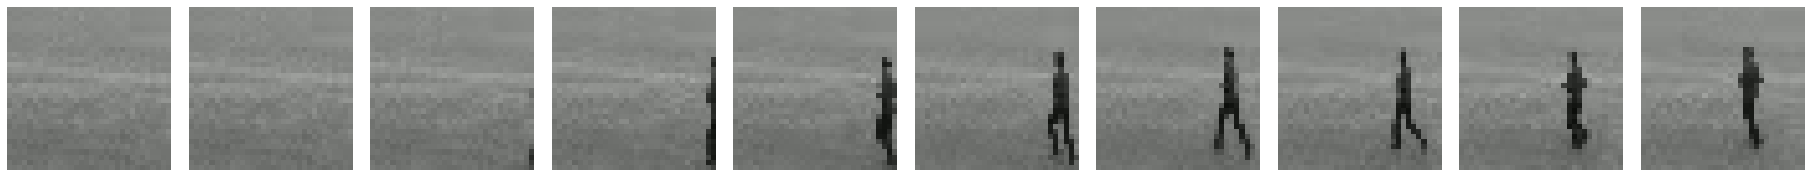

In [5]:
from openstl.utils import show_video_line

# show the given frames from an example
example_idx = 0
show_video_line(train_x[example_idx], ncols=pre_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

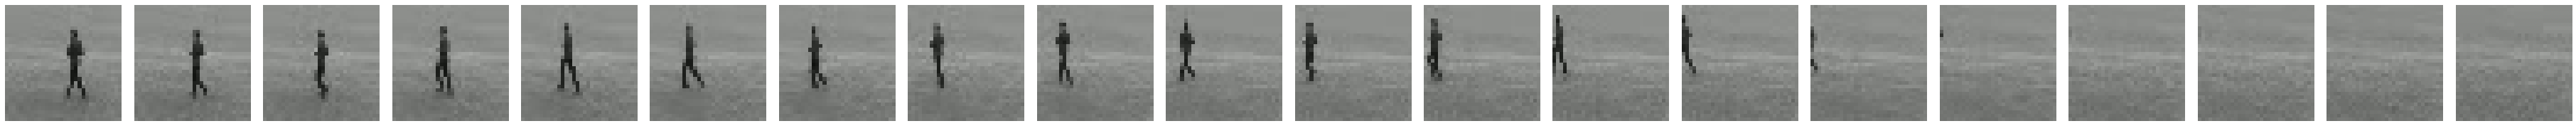

In [6]:
# show the future frames from an example
example_idx = 0
show_video_line(train_y[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

## 2. Utilize cumtom data

### 2.1 Define the dataset

We first define the `CustomDataset` to use the provided dataset. 

For real video prediction, to facilitate model optimization, we strongly recommend users to use frames represented as `float32` with values in the range of $[0, 1]$, rather than frames represented as `uint8` with values in the range of $[0, 255]$. For other types of data, we also provide the option to `normalize` in the `CustomDataset`.

In [7]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

#### hyperparameters

`batch_size`: the size of a batch

In [8]:
batch_size = 1

In [9]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)

In [10]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

## 3. Train and evaluate

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Here, we set `epoch = 3` as an example for simple training. The actual value of epoch in your project depends on the complexity of your dataset. Generally, a good starting point is `epoch = 100`.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

In [11]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 3,
    'lr': 0.001,   
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [10, 3, 32, 32],
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py',
    
    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`. 

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [12]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test))

Use non-distributed mode with GPU: cuda:0
Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:40:17) [GCC 9.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.0_bu.TC445_37.28845127_0
GPU 0,1: NVIDIA A100-SXM4-80GB
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.7.1
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.6.0 (Git Hash 5ef631a030a6f73131c77892041042805a06064f)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.0
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,co

### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation. 

Here we go!

In [13]:
print('>'*35 + ' training ' + '<'*35)
exp.train()

print('>'*35 + ' testing  ' + '<'*35)
exp.test()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


train loss: 0.0783 | data time: 0.0029: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 43.1 task/s, elapsed: 0s, ETA:     0sval	 mse:577.9671020507812, mae:988.0562133789062
[2023-06-28 02:05:23] Intermediate result: 577.9671020507812  (Index 0)



/root/anaconda3/envs/MetaVP/lib/python3.9/site-packages/json_tricks/encoders.py:367: UserWarning: json-tricks: numpy scalar serialization is experimental and may work differently in future versions
  warnings.warn('json-tricks: numpy scalar serialization is experimental and may work differently in future versions')


Epoch: 1, Steps: 2 | Lr: 0.0008117 | Train Loss: 0.0925540 | Vali Loss: 0.1881403

Validation loss decreased (inf --> 0.188140).  Saving model ...


train loss: 0.0621 | data time: 0.0064: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s]

[>>>>>>>>>>>>>>>>>                 ] 1/2, 35.2 task/s, elapsed: 0s, ETA:     0s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 18.5 task/s, elapsed: 0s, ETA:     0sval	 mse:130.25579833984375, mae:532.03125
[2023-06-28 02:05:24] Intermediate result: 130.25579833984375  (Index 1)
Epoch: 2, Steps: 2 | Lr: 0.0001335 | Train Loss: 0.1252185 | Vali Loss: 0.0424010

Validation loss decreased (0.188140 --> 0.042401).  Saving model ...


train loss: 0.0414 | data time: 0.0207: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 67.1 task/s, elapsed: 0s, ETA:     0sval	 mse:122.76216125488281, mae:516.6934204101562
[2023-06-28 02:05:25] Intermediate result: 122.76216125488281  (Index 2)


Epoch: 3, Steps: 2 | Lr: 0.0001335 | Train Loss: 0.0426705 | Vali Loss: 0.0399616

Validation loss decreased (0.042401 --> 0.039962).  Saving model ...
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 61.4 task/s, elapsed: 0s, ETA:     0smse:121.41651916503906, mae:513.7880859375


121.41652

## Visualization

By employing the `show_video_line` and `show_video_gif_multiple` functions provided by `OpenSTL`, we can visualize the input, ground truth, and predicted frames, as well as generate corresponding GIFs.

### 4.1 Visualize in a line

In [ ]:
import numpy as np
from openstl.utils import show_video_line

# show the given frames from an example
inputs = np.load('./work_dirs/custom_exp/saved/inputs.npy')
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')
trues = np.load('./work_dirs/custom_exp/saved/trues.npy')

example_idx = 0
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

In [ ]:
example_idx = 0
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

### 4.2 Generate a GIF

In [ ]:
from openstl.utils import show_video_gif_multiple

example_idx = 0
show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=True, out_path='example.gif')